
![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - masked sky
In this notebook you perfrom QE and iterative lensing reconstruction for a single simulation, and for a masked sky.
This notebook is very similar to the [full-sky tutorial](https://github.com/NextGenCMB/delensalot/blob/main/notebooks/examples/interactive_mwe.ipynb), but this time, we assume that the data only contains a part of the sky.

The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.

We generate a simple mask leaving us with a sky fraction of about $8$ percent.
Masked data for iterative lensing reconstruction results in a large mean-field, and biases the lensing potential estimate.
To remove this bias, you will estimate the mean-field from a set of simulations.

We will use an isotropic noise model and ignore that the data is masked when we deproject the B-modes.
This is an approximation, and it were better to use the `build_OBD` job to create a better noise model.
However, this is out of scope for this tutorial.

At the end of this tutorial, you will plot the mean-field subtracted lensing potential estimate and obtain delensed power spectra to calculate the residual lensing amplitude on a masked sky with binned power spectra.

The configuration file is [here](https://github.com/NextGenCMB/delensalot/blob/main/notebooks/examples/conf_mwe_maskedsky.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


In [1]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj
if "SCRATCH" not in os.environ:
    os.environ["SCRATCH"] = "/mnt/c/Users/sebas/OneDrive/SCRATCH"
import numpy as np
import healpy as hp

from delensalot.utils_hp import almxfl, alm_copy
import matplotlib.pyplot as plt

from plancklens import utils, qresp
import delensalot
from delensalot.run import run

from delensalot.lerepi.visalot import plot_helper as ph

bpl, bpu = (10,1000)
def scale_and_bandpass(data):
    ll = np.arange(0,3001)
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)

fn = opj(os.getcwd(), 'conf_mwe_maskedsky_center.py')

mpi.py: Plancklens.mpi disabled as per environ variable 

cond4mpi does not exists. No MPI loaded
MSC: reverting to standard healpy


# Create mask
Any mask will do as long as the remaining sky fraction is large enough to calculate an unbinned power spectrum of the residual maps later

fsky: 0.083


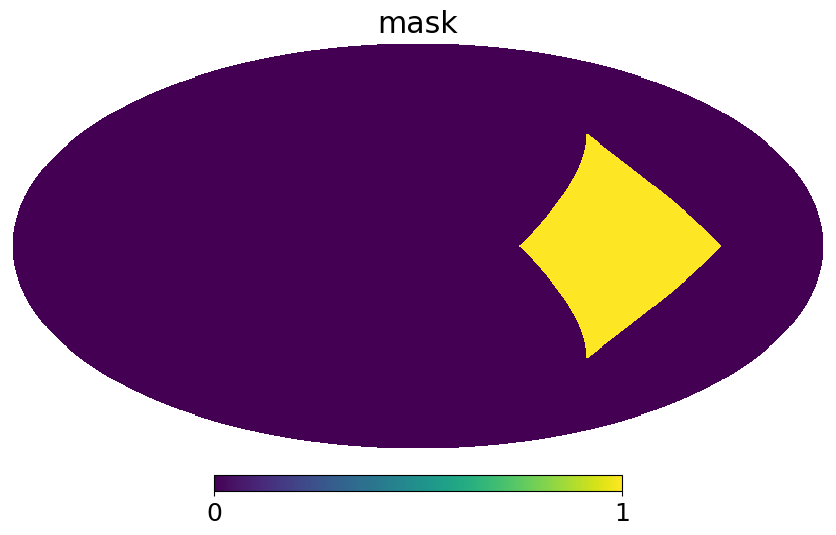

In [3]:
m = np.zeros(hp.nside2npix(1))
m[[7]] = 1
# rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=2048),0.1))
mask = hp.ud_grade(m, nside_out=256)
hp.mollview(mask, title='mask')
# hp.mollview(rhits, title='rhits')
print('fsky: {:.3f}'.format(np.mean(m)))

In [2]:
m = np.zeros(hp.nside2npix(1))
m[[7]] = 1
# rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=2048),0.1))
mask = hp.ud_grade(m, nside_out=2048)
# hp.mollview(mask, title='mask')
# hp.mollview(rhits, title='rhits')
print('fsky: {:.3f}'.format(np.mean(m)))

mask_fn = opj(os.environ['SCRATCH'], 'delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky_center/mask.fits')
# rhits_fn = opj(os.environ['SCRATCH'], 'delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky_south/rhits.fits')
if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    # hp.write_map(rhits_fn, rhits)
    print('mask and rhits stored at {}'.format(os.path.dirname(mask_fn)))

fsky: 0.083
mask and rhits stored at /mnt/c/Users/sebas/OneDrive/SCRATCH/delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky_center


# QE lensing reconstruction
The following cell,
 
 * line 1: selects the configuration file,
 * line 2: initialises delensalot for a QE lensing reconstruction job (`job_id`),
 * line 3: perfroms lensing reconstruction and calculates both, the lensing potential, and the $B$-lensing template.

`.run()` also generates CMB simulations and stores them at `DLENSALOT_data.class_parameters.lib_dir`. If this path is not convenient, please choose one that works for you.

This cell will take a while as it also calculates the QE mean-field (and is calculated from $5$ simulations in this tutorial). This is needed, as the masking of the data induces a strong bias in the low-$L$ lensing potential.
For QE, once the mean-field is calculated, it is subtracted from the QE lensing potential estimate to remove this bias.
This QE estimate is later used as a starting point for iterative lensing reconstruction.

This cell takes ~10 min * N (QE estimates to calculate mean-field) + ~30 sec * 20 N (generation of simulation data), and N is the number of simulations

In [4]:
fn = opj(os.getcwd(), 'conf_mwe_maskedsky_center.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True)
ana_mwe.run()
ana_mwe = ana_mwe.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 16:09:03


## Check QE results

`get_plm` and `get_meanfield_normalized` returns the normalized lensing potential and mean-field.
Let us plot it to see if they look as expected

In [3]:
ll = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

mf_QE = ana_mwe.get_meanfield_normalized(0)
plm_QE = ana_mwe.get_plm(0, [0])

AttributeError: 'MAP_lr' object has no attribute 'get_meanfield_normalized'

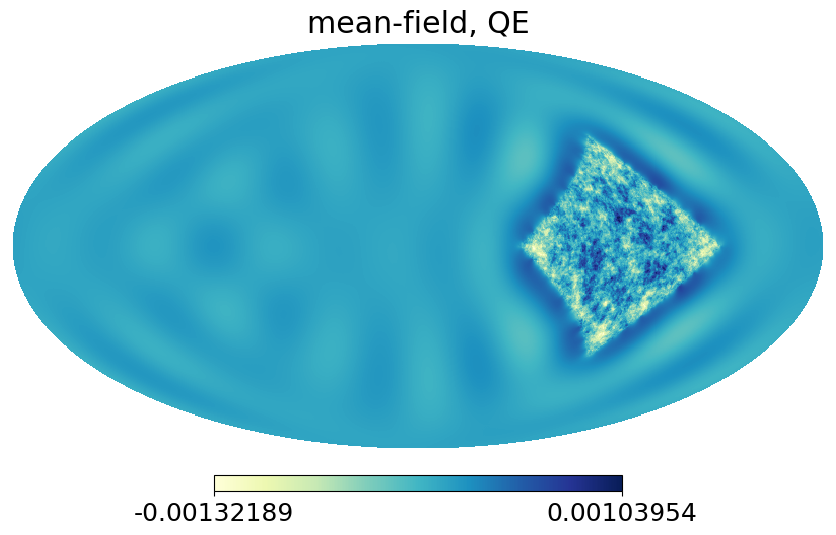

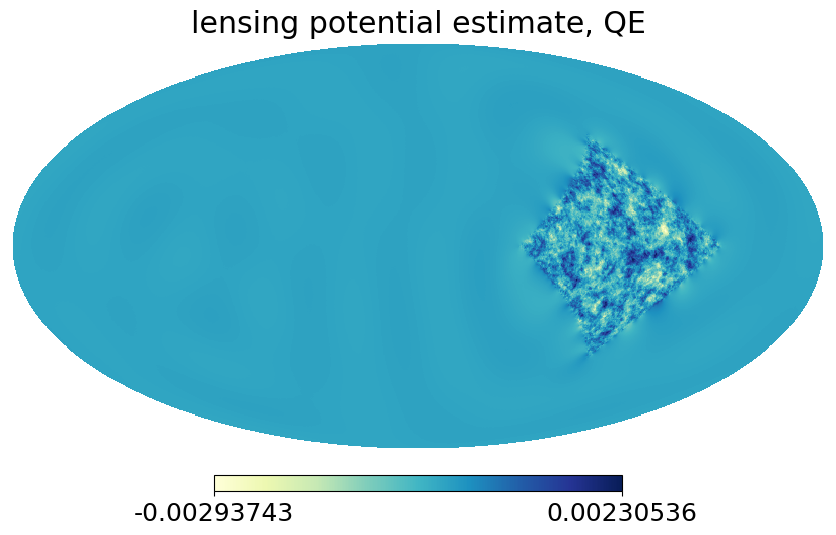

In [6]:
hp.mollview(hp.alm2map(scale_and_bandpass(mf_QE), nside=1024), title='mean-field, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=1024), title='lensing potential estimate, QE', cmap='YlGnBu')

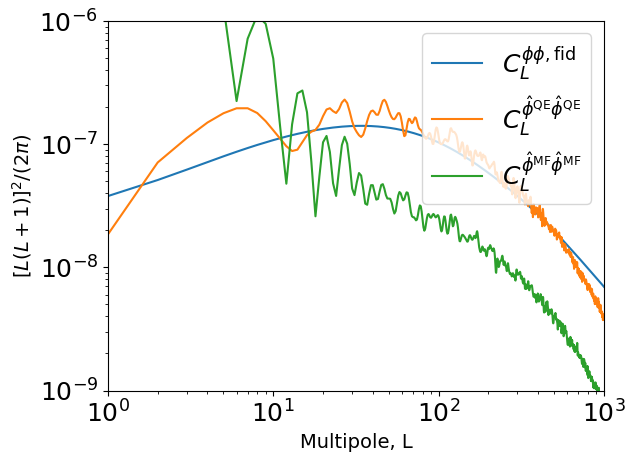

In [7]:
plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')

plt.plot(scale_factor*hp.alm2cl(mf_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MF}\hat{\phi}^{\rm MF}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,1e-6)
plt.yscale('log')

# iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The settings can be chosen in the configuration file.

In [6]:
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=True)
ana_mwe.run()
ana_mwe = ana_mwe.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

INFO:: 05-19 16:30:: delensalot.lerepi.core.handler.log - load_configfile() Started: /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/notebooks/examples/conf_mwe_maskedsky_center.py
INFO:: 05-19 16:30:: delensalot.lerepi.core.metamodel.dlensalot_mm.__attrs_post_init__ - Setting default, using P_FS_CMBS4:
	{'meta': {'version': '0.2'}, 'job': {'jobs': ['generate_sim', 'QE_lensrec', 'MAP_lensrec']}, 'data': {'beam': 1.0, 'nlev_t': 1.0, 'nlev_p': 1.0, 'epsilon': 1e-05, 'nside': 2048, 'class_parameters': {'lmax': 4096, 'cls_unl': {'tt': array([0.00000000e+00, 3.15384486e+03, 1.08426834e+03, ...,
       9.66229400e-10, 9.65260803e-10, 9.64292720e-10]), 'ee': array([0.00000000e+00, 0.00000000e+00, 3.62414129e-02, ...,
       2.00006407e-12, 1.99423451e-12, 1.98828000e-12]), 'bb': array([0., 0., 0., ..., 0., 0., 0.]), 'te': array([0.00000000e+00, 0.00000000e+00, 2.93875049e+00, ...,
       1.40842175e-11, 1.40724986e-11, 1.40607859e-11]), 'pp': array([0.00000000e+00, 5.94954817e-08, 


Total wall clock time for adjoint_synthesis_general: 4.918s
|
+- updateAlm                         : 90.89% (4.4701s)
|  |
|  +- leg2alm                           : 91.16% (4.0750s)
|  +- theta resampling and deconvolution:  4.82% (0.2156s)
|  +- phi FFT and deconvolution         :  4.00% (0.1789s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  8.53% (0.4197s)
+- build_planes                      :  0.58% (0.0284s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.018869] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:04.312643] (26.1%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (19.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (1.6%)  
  build_angles                         :  [0:00:03.528999] (21.4%)  
  polrot (ducc)                        :  [0:00:00.048650] (0.3%)  
  weighting                            :  [0:00:00.015278] (0.1%)  
  get_pointing                         :  [0:00:00.000087] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:04.919469] (29.8%)  
  lenmap2gclm                          :  [0:00:04.919564] (29.8%)  
  lengclm bwd                          :  [0:00:12.811827] (77.6%)  
  Total                                :  [0:00:16.517121] d:h:m:s:mus
** gclm2lenmap: inconsistent input dtype !



Total wall clock time for synthesis_general: 5.63s
|
+- getPlane                          : 93.60% (5.2692s)
|  |
|  +- alm2leg                           : 91.72% (4.8329s)
|  +- theta resampling and deconvolution:  4.76% (0.2508s)
|  +- phi FFT and dconvolution          :  3.51% (0.1849s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.40% (0.3604s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.018869] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:04.312643] (19.4%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (14.5%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (1.2%)  
  build_angles                         :  [0:00:03.528999] (15.9%)  
  polrot (ducc)                        :  [0:00:00.062268] (0.3%)  
  weighting                            :  [0:00:00.015278] (0.1%)  
  get_pointing                         :  [0:00:00.000087] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:04.919469] (22.1%)  
  lenmap2gclm                          :  [0:00:04.919564] (22.1%)  
  lengclm bwd                          :  [0:00:12.811827] (57.6%)  
  synthesis general (STANDARD)         :  [0:00:05.646636] (25.4%)  
  gclm2lenmap                          :  [0:00:05.660259] (25.4%)  
  Total                                :  [0:00:22.254508] d:h:m:s:mus



Total wall clock time for adjoint_synthesis_general: 4.882s
|
+- updateAlm                         : 92.34% (4.5084s)
|  |
|  +- leg2alm                           : 91.50% (4.1252s)
|  +- theta resampling and deconvolution:  4.87% (0.2196s)
|  +- phi FFT and deconvolution         :  3.62% (0.1631s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  6.94% (0.3391s)
+- build_planes                      :  0.71% (0.0348s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.033741] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:08.196345] (19.6%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (7.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.6%)  
  build_angles                         :  [0:00:03.528999] (8.4%)  
  polrot (ducc)                        :  [0:00:00.078963] (0.2%)  
  weighting                            :  [0:00:00.030655] (0.1%)  
  get_pointing                         :  [0:00:00.000146] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:09.802726] (23.5%)  
  lenmap2gclm                          :  [0:00:09.802888] (23.5%)  
  lengclm bwd                          :  [0:00:21.625822] (51.8%)  
  synthesis general (STANDARD)         :  [0:00:05.646636] (13.5%)  
  gclm2lenmap                          :  [0:00:05.660259] (13.6%)  
  adjoint_synthesis                    :  [0:00:04.148607] (9.9%)  
  lengclm fwd                          :  


Total wall clock time for synthesis_general: 5.709s
|
+- getPlane                          : 94.10% (5.3723s)
|  |
|  +- alm2leg                           : 92.06% (4.9456s)
|  +- theta resampling and deconvolution:  4.30% (0.2312s)
|  +- phi FFT and dconvolution          :  3.63% (0.1948s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  5.90% (0.3368s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.033741] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:08.196345] (17.1%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (6.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.5%)  
  build_angles                         :  [0:00:03.528999] (7.4%)  
  polrot (ducc)                        :  [0:00:00.092512] (0.2%)  
  weighting                            :  [0:00:00.030655] (0.1%)  
  get_pointing                         :  [0:00:00.000146] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:09.802726] (20.4%)  
  lenmap2gclm                          :  [0:00:09.802888] (20.4%)  
  lengclm bwd                          :  [0:00:21.625822] (45.1%)  
  synthesis general (STANDARD)         :  [0:00:11.373237] (23.7%)  
  gclm2lenmap                          :  [0:00:11.400414] (23.8%)  
  adjoint_synthesis                    :  [0:00:04.148607] (8.6%)  
  lengclm fwd                          :  


Total wall clock time for adjoint_synthesis_general: 5.124s
|
+- updateAlm                         : 91.34% (4.6796s)
|  |
|  +- leg2alm                           : 92.12% (4.3108s)
|  +- theta resampling and deconvolution:  4.48% (0.2096s)
|  +- phi FFT and deconvolution         :  3.39% (0.1587s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  8.09% (0.4145s)
+- build_planes                      :  0.57% (0.0294s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.048831] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:12.039615] (17.8%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (4.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.4%)  
  build_angles                         :  [0:00:03.528999] (5.2%)  
  polrot (ducc)                        :  [0:00:00.108067] (0.2%)  
  weighting                            :  [0:00:00.044643] (0.1%)  
  get_pointing                         :  [0:00:00.000190] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:14.927264] (22.1%)  
  lenmap2gclm                          :  [0:00:14.927475] (22.1%)  
  lengclm bwd                          :  [0:00:30.638346] (45.3%)  
  synthesis general (STANDARD)         :  [0:00:11.373237] (16.8%)  
  gclm2lenmap                          :  [0:00:11.400414] (16.9%)  
  adjoint_synthesis                    :  [0:00:08.273668] (12.2%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.757s
|
+- getPlane                          : 93.34% (5.3734s)
|  |
|  +- alm2leg                           : 91.97% (4.9418s)
|  +- theta resampling and deconvolution:  4.38% (0.2356s)
|  +- phi FFT and dconvolution          :  3.64% (0.1955s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.66% (0.3836s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.048831] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:12.039615] (16.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (4.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.4%)  
  build_angles                         :  [0:00:03.528999] (4.8%)  
  polrot (ducc)                        :  [0:00:00.122323] (0.2%)  
  weighting                            :  [0:00:00.044643] (0.1%)  
  get_pointing                         :  [0:00:00.000190] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:14.927264] (20.1%)  
  lenmap2gclm                          :  [0:00:14.927475] (20.1%)  
  lengclm bwd                          :  [0:00:30.638346] (41.4%)  
  synthesis general (STANDARD)         :  [0:00:17.148471] (23.1%)  
  gclm2lenmap                          :  [0:00:17.189911] (23.2%)  
  adjoint_synthesis                    :  [0:00:08.273668] (11.2%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.252s
|
+- updateAlm                         : 92.69% (4.8678s)
|  |
|  +- leg2alm                           : 92.28% (4.4921s)
|  +- theta resampling and deconvolution:  4.26% (0.2072s)
|  +- phi FFT and deconvolution         :  3.45% (0.1678s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  6.81% (0.3576s)
+- build_planes                      :  0.50% (0.0263s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.063417] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:15.908839] (16.9%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (3.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.3%)  
  build_angles                         :  [0:00:03.528999] (3.8%)  
  polrot (ducc)                        :  [0:00:00.137426] (0.1%)  
  weighting                            :  [0:00:00.058628] (0.1%)  
  get_pointing                         :  [0:00:00.000231] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:20.179861] (21.5%)  
  lenmap2gclm                          :  [0:00:20.180117] (21.5%)  
  lengclm bwd                          :  [0:00:39.803904] (42.4%)  
  synthesis general (STANDARD)         :  [0:00:17.148471] (18.3%)  
  gclm2lenmap                          :  [0:00:17.189911] (18.3%)  
  adjoint_synthesis                    :  [0:00:12.426217] (13.2%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.598s
|
+- getPlane                          : 93.70% (5.2452s)
|  |
|  +- alm2leg                           : 91.93% (4.8219s)
|  +- theta resampling and deconvolution:  4.37% (0.2293s)
|  +- phi FFT and dconvolution          :  3.69% (0.1935s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.30% (0.3524s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.063417] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:15.908839] (15.9%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (3.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.3%)  
  build_angles                         :  [0:00:03.528999] (3.5%)  
  polrot (ducc)                        :  [0:00:00.158732] (0.2%)  
  weighting                            :  [0:00:00.058628] (0.1%)  
  get_pointing                         :  [0:00:00.000231] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:20.179861] (20.1%)  
  lenmap2gclm                          :  [0:00:20.180117] (20.1%)  
  lengclm bwd                          :  [0:00:39.803904] (39.7%)  
  synthesis general (STANDARD)         :  [0:00:22.767553] (22.7%)  
  gclm2lenmap                          :  [0:00:22.830308] (22.7%)  
  adjoint_synthesis                    :  [0:00:12.426217] (12.4%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.763s
|
+- updateAlm                         : 93.79% (5.4045s)
|  |
|  +- leg2alm                           : 91.70% (4.9561s)
|  +- phi FFT and deconvolution         :  4.19% (0.2262s)
|  +- theta resampling and deconvolution:  4.10% (0.2217s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  5.68% (0.3273s)
+- build_planes                      :  0.53% (0.0308s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.078316] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:19.719820] (16.4%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (2.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.2%)  
  build_angles                         :  [0:00:03.528999] (2.9%)  
  polrot (ducc)                        :  [0:00:00.173511] (0.1%)  
  weighting                            :  [0:00:00.072508] (0.1%)  
  get_pointing                         :  [0:00:00.000271] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:25.943449] (21.6%)  
  lenmap2gclm                          :  [0:00:25.943751] (21.6%)  
  lengclm bwd                          :  [0:00:49.422096] (41.1%)  
  synthesis general (STANDARD)         :  [0:00:22.767553] (18.9%)  
  gclm2lenmap                          :  [0:00:22.830308] (19.0%)  
  adjoint_synthesis                    :  [0:00:16.412109] (13.6%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 7.762s
|
+- getPlane                          : 94.15% (7.3076s)
|  |
|  +- alm2leg                           : 92.20% (6.7376s)
|  +- theta resampling and deconvolution:  4.40% (0.3216s)
|  +- phi FFT and dconvolution          :  3.39% (0.2475s)
|  +- dealing with borders              :  0.01% (0.0008s)
|  
+- interpol (u2nu)                   :  5.85% (0.4543s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.078316] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:19.719820] (15.3%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (2.5%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.2%)  
  build_angles                         :  [0:00:03.528999] (2.7%)  
  polrot (ducc)                        :  [0:00:00.191779] (0.1%)  
  weighting                            :  [0:00:00.072508] (0.1%)  
  get_pointing                         :  [0:00:00.000271] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:25.943449] (20.1%)  
  lenmap2gclm                          :  [0:00:25.943751] (20.1%)  
  lengclm bwd                          :  [0:00:49.422096] (38.3%)  
  synthesis general (STANDARD)         :  [0:00:30.551247] (23.7%)  
  gclm2lenmap                          :  [0:00:30.632277] (23.7%)  
  adjoint_synthesis                    :  [0:00:16.412109] (12.7%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.832s
|
+- updateAlm                         : 91.83% (5.3549s)
|  |
|  +- leg2alm                           : 91.37% (4.8929s)
|  +- theta resampling and deconvolution:  5.00% (0.2678s)
|  +- phi FFT and deconvolution         :  3.62% (0.1936s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.58% (0.4422s)
+- build_planes                      :  0.59% (0.0344s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.099239] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:24.214158] (15.9%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (2.1%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.2%)  
  build_angles                         :  [0:00:03.528999] (2.3%)  
  polrot (ducc)                        :  [0:00:00.210318] (0.1%)  
  weighting                            :  [0:00:00.092252] (0.1%)  
  get_pointing                         :  [0:00:00.000325] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:31.775961] (20.9%)  
  lenmap2gclm                          :  [0:00:31.776322] (20.9%)  
  lengclm bwd                          :  [0:00:59.808238] (39.3%)  
  synthesis general (STANDARD)         :  [0:00:30.551247] (20.1%)  
  gclm2lenmap                          :  [0:00:30.632277] (20.1%)  
  adjoint_synthesis                    :  [0:00:21.402434] (14.1%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 6.725s
|
+- getPlane                          : 93.73% (6.3035s)
|  |
|  +- alm2leg                           : 92.59% (5.8363s)
|  +- theta resampling and deconvolution:  4.37% (0.2756s)
|  +- phi FFT and dconvolution          :  3.03% (0.1910s)
|  +- dealing with borders              :  0.01% (0.0007s)
|  
+- interpol (u2nu)                   :  6.27% (0.4216s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.099239] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:24.214158] (15.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (2.0%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.2%)  
  build_angles                         :  [0:00:03.528999] (2.2%)  
  polrot (ducc)                        :  [0:00:00.234357] (0.1%)  
  weighting                            :  [0:00:00.092252] (0.1%)  
  get_pointing                         :  [0:00:00.000325] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:31.775961] (19.9%)  
  lenmap2gclm                          :  [0:00:31.776322] (19.9%)  
  lengclm bwd                          :  [0:00:59.808238] (37.5%)  
  synthesis general (STANDARD)         :  [0:00:37.299838] (23.4%)  
  gclm2lenmap                          :  [0:00:37.404916] (23.4%)  
  adjoint_synthesis                    :  [0:00:21.402434] (13.4%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.274s
|
+- updateAlm                         : 91.90% (4.8466s)
|  |
|  +- leg2alm                           : 91.48% (4.4336s)
|  +- theta resampling and deconvolution:  5.23% (0.2535s)
|  +- phi FFT and deconvolution         :  3.28% (0.1589s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.47% (0.3941s)
+- build_planes                      :  0.62% (0.0328s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.118007] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:28.238511] (15.7%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (2.0%)  
  polrot (ducc)                        :  [0:00:00.250525] (0.1%)  
  weighting                            :  [0:00:00.109758] (0.1%)  
  get_pointing                         :  [0:00:00.000379] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:37.050425] (20.6%)  
  lenmap2gclm                          :  [0:00:37.050846] (20.6%)  
  lengclm bwd                          :  [0:01:09.159584] (38.5%)  
  synthesis general (STANDARD)         :  [0:00:37.299838] (20.7%)  
  gclm2lenmap                          :  [0:00:37.404916] (20.8%)  
  adjoint_synthesis                    :  [0:00:25.764011] (14.3%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 6.053s
|
+- getPlane                          : 92.54% (5.6013s)
|  |
|  +- alm2leg                           : 91.27% (5.1123s)
|  +- theta resampling and deconvolution:  4.88% (0.2735s)
|  +- phi FFT and dconvolution          :  3.84% (0.2149s)
|  +- dealing with borders              :  0.01% (0.0007s)
|  
+- interpol (u2nu)                   :  7.45% (0.4512s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.118007] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:28.238511] (15.1%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.9%)  
  polrot (ducc)                        :  [0:00:00.266716] (0.1%)  
  weighting                            :  [0:00:00.109758] (0.1%)  
  get_pointing                         :  [0:00:00.000379] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:37.050425] (19.8%)  
  lenmap2gclm                          :  [0:00:37.050846] (19.8%)  
  lengclm bwd                          :  [0:01:09.159584] (37.0%)  
  synthesis general (STANDARD)         :  [0:00:43.375500] (23.2%)  
  gclm2lenmap                          :  [0:00:43.496777] (23.3%)  
  adjoint_synthesis                    :  [0:00:25.764011] (13.8%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 4.814s
|
+- updateAlm                         : 91.92% (4.4247s)
|  |
|  +- leg2alm                           : 90.95% (4.0241s)
|  +- theta resampling and deconvolution:  4.79% (0.2118s)
|  +- phi FFT and deconvolution         :  4.25% (0.1882s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.51% (0.3618s)
+- build_planes                      :  0.57% (0.0273s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.132824] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:31.931158] (15.5%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.7%)  
  polrot (ducc)                        :  [0:00:00.291635] (0.1%)  
  weighting                            :  [0:00:00.125694] (0.1%)  
  get_pointing                         :  [0:00:00.000420] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:41.865022] (20.4%)  
  lenmap2gclm                          :  [0:00:41.865488] (20.4%)  
  lengclm bwd                          :  [0:01:17.722568] (37.8%)  
  synthesis general (STANDARD)         :  [0:00:43.375500] (21.1%)  
  gclm2lenmap                          :  [0:00:43.496777] (21.2%)  
  adjoint_synthesis                    :  [0:00:29.980059] (14.6%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.38s
|
+- getPlane                          : 94.40% (5.0794s)
|  |
|  +- alm2leg                           : 92.29% (4.6876s)
|  +- theta resampling and deconvolution:  4.35% (0.2208s)
|  +- phi FFT and dconvolution          :  3.35% (0.1703s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  5.59% (0.3010s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.132824] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:31.931158] (15.1%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.5%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.7%)  
  polrot (ducc)                        :  [0:00:00.306463] (0.1%)  
  weighting                            :  [0:00:00.125694] (0.1%)  
  get_pointing                         :  [0:00:00.000420] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:41.865022] (19.8%)  
  lenmap2gclm                          :  [0:00:41.865488] (19.8%)  
  lengclm bwd                          :  [0:01:17.722568] (36.7%)  
  synthesis general (STANDARD)         :  [0:00:48.775028] (23.0%)  
  gclm2lenmap                          :  [0:00:48.911139] (23.1%)  
  adjoint_synthesis                    :  [0:00:29.980059] (14.2%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.198s
|
+- updateAlm                         : 92.12% (4.7885s)
|  |
|  +- leg2alm                           : 91.02% (4.3586s)
|  +- theta resampling and deconvolution:  5.14% (0.2462s)
|  +- phi FFT and deconvolution         :  3.83% (0.1832s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  7.30% (0.3795s)
+- build_planes                      :  0.58% (0.0302s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.149251] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:35.805764] (15.5%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.5%)  
  polrot (ducc)                        :  [0:00:00.320977] (0.1%)  
  weighting                            :  [0:00:00.141011] (0.1%)  
  get_pointing                         :  [0:00:00.000464] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:47.064270] (20.4%)  
  lenmap2gclm                          :  [0:00:47.064783] (20.4%)  
  lengclm bwd                          :  [0:01:26.842748] (37.6%)  
  synthesis general (STANDARD)         :  [0:00:48.775028] (21.1%)  
  gclm2lenmap                          :  [0:00:48.911139] (21.2%)  
  adjoint_synthesis                    :  [0:00:33.858489] (14.6%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.558s
|
+- getPlane                          : 93.83% (5.2148s)
|  |
|  +- alm2leg                           : 92.05% (4.8004s)
|  +- theta resampling and deconvolution:  4.16% (0.2171s)
|  +- phi FFT and dconvolution          :  3.77% (0.1968s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- interpol (u2nu)                   :  6.17% (0.3430s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.149251] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:35.805764] (15.1%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.5%)  
  polrot (ducc)                        :  [0:00:00.335502] (0.1%)  
  weighting                            :  [0:00:00.141011] (0.1%)  
  get_pointing                         :  [0:00:00.000464] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:47.064270] (19.8%)  
  lenmap2gclm                          :  [0:00:47.064783] (19.8%)  
  lengclm bwd                          :  [0:01:26.842748] (36.5%)  
  synthesis general (STANDARD)         :  [0:00:54.369064] (22.9%)  
  gclm2lenmap                          :  [0:00:54.519707] (22.9%)  
  adjoint_synthesis                    :  [0:00:33.858489] (14.2%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.287s
|
+- getPlane                          : 94.10% (4.9757s)
|  |
|  +- alm2leg                           : 91.63% (4.5591s)
|  +- theta resampling and deconvolution:  4.71% (0.2346s)
|  +- phi FFT and dconvolution          :  3.64% (0.1813s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  5.90% (0.3118s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.149251] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:35.805764] (13.9%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.3%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.4%)  
  polrot (ducc)                        :  [0:00:00.351140] (0.1%)  
  weighting                            :  [0:00:00.141011] (0.1%)  
  get_pointing                         :  [0:00:00.000464] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:47.064270] (18.2%)  
  lenmap2gclm                          :  [0:00:47.064783] (18.2%)  
  lengclm bwd                          :  [0:01:26.842748] (33.6%)  
  synthesis general (STANDARD)         :  [0:00:59.673454] (23.1%)  
  gclm2lenmap                          :  [0:00:59.839744] (23.2%)  
  adjoint_synthesis                    :  [0:00:37.857193] (14.7%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.493s
|
+- getPlane                          : 93.86% (5.1557s)
|  |
|  +- alm2leg                           : 91.91% (4.7386s)
|  +- theta resampling and deconvolution:  4.61% (0.2379s)
|  +- phi FFT and dconvolution          :  3.46% (0.1785s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.14% (0.3370s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.149251] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:35.805764] (13.6%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.235251] (1.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.261445] (0.1%)  
  build_angles                         :  [0:00:03.528999] (1.3%)  
  polrot (ducc)                        :  [0:00:00.372430] (0.1%)  
  weighting                            :  [0:00:00.141011] (0.1%)  
  get_pointing                         :  [0:00:00.000464] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:47.064270] (17.8%)  
  lenmap2gclm                          :  [0:00:47.064783] (17.8%)  
  lengclm bwd                          :  [0:01:26.842748] (32.9%)  
  synthesis general (STANDARD)         :  [0:01:05.187458] (24.7%)  
  gclm2lenmap                          :  [0:01:05.375046] (24.8%)  
  adjoint_synthesis                    :  [0:00:37.857193] (14.3%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.513s
|
+- updateAlm                         : 92.02% (5.0730s)
|  |
|  +- leg2alm                           : 89.85% (4.5579s)
|  +- theta resampling and deconvolution:  5.89% (0.2988s)
|  +- phi FFT and deconvolution         :  4.25% (0.2158s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.44% (0.4100s)
+- build_planes                      :  0.54% (0.0300s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.014172] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:03.914110] (23.6%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (18.0%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (1.8%)  
  build_angles                         :  [0:00:03.319849] (20.0%)  
  polrot (ducc)                        :  [0:00:00.061435] (0.4%)  
  weighting                            :  [0:00:00.017909] (0.1%)  
  get_pointing                         :  [0:00:00.000049] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:05.514017] (33.3%)  
  lenmap2gclm                          :  [0:00:05.514070] (33.3%)  
  lengclm bwd                          :  [0:00:12.804696] (77.3%)  
  Total                                :  [0:00:16.564777] d:h:m:s:mus
** gclm2lenmap: inconsistent input dtype !



Total wall clock time for synthesis_general: 6.436s
|
+- getPlane                          : 93.95% (6.0466s)
|  |
|  +- alm2leg                           : 92.29% (5.5803s)
|  +- theta resampling and deconvolution:  4.41% (0.2669s)
|  +- phi FFT and dconvolution          :  3.29% (0.1987s)
|  +- dealing with borders              :  0.01% (0.0007s)
|  
+- interpol (u2nu)                   :  6.05% (0.3896s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.014172] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:03.914110] (16.8%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (12.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (1.3%)  
  build_angles                         :  [0:00:03.319849] (14.2%)  
  polrot (ducc)                        :  [0:00:00.084657] (0.4%)  
  weighting                            :  [0:00:00.017909] (0.1%)  
  get_pointing                         :  [0:00:00.000049] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:05.514017] (23.6%)  
  lenmap2gclm                          :  [0:00:05.514070] (23.6%)  
  lengclm bwd                          :  [0:00:12.804696] (54.9%)  
  synthesis general (STANDARD)         :  [0:00:06.644337] (28.5%)  
  gclm2lenmap                          :  [0:00:06.667567] (28.6%)  
  Total                                :  [0:00:23.331183] d:h:m:s:mus



Total wall clock time for adjoint_synthesis_general: 5.777s
|
+- updateAlm                         : 91.33% (5.2760s)
|  |
|  +- leg2alm                           : 91.57% (4.8311s)
|  +- theta resampling and deconvolution:  4.91% (0.2590s)
|  +- phi FFT and deconvolution         :  3.51% (0.1852s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.98% (0.4611s)
+- build_planes                      :  0.69% (0.0399s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.041548] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:08.801889] (19.0%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (6.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.7%)  
  build_angles                         :  [0:00:03.319849] (7.2%)  
  polrot (ducc)                        :  [0:00:00.108723] (0.2%)  
  weighting                            :  [0:00:00.038189] (0.1%)  
  get_pointing                         :  [0:00:00.000106] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:11.292041] (24.3%)  
  lenmap2gclm                          :  [0:00:11.292157] (24.3%)  
  lengclm bwd                          :  [0:00:23.542311] (50.7%)  
  synthesis general (STANDARD)         :  [0:00:06.644337] (14.3%)  
  gclm2lenmap                          :  [0:00:06.667567] (14.4%)  
  adjoint_synthesis                    :  [0:00:04.636000] (10.0%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 7.372s
|
+- getPlane                          : 93.28% (6.8760s)
|  |
|  +- alm2leg                           : 90.87% (6.2480s)
|  +- theta resampling and deconvolution:  5.10% (0.3509s)
|  +- phi FFT and dconvolution          :  4.02% (0.2763s)
|  +- dealing with borders              :  0.01% (0.0008s)
|  
+- interpol (u2nu)                   :  6.72% (0.4955s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.041548] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:08.801889] (16.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (5.5%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.6%)  
  build_angles                         :  [0:00:03.319849] (6.1%)  
  polrot (ducc)                        :  [0:00:00.150946] (0.3%)  
  weighting                            :  [0:00:00.038189] (0.1%)  
  get_pointing                         :  [0:00:00.000106] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:11.292041] (20.7%)  
  lenmap2gclm                          :  [0:00:11.292157] (20.7%)  
  lengclm bwd                          :  [0:00:23.542311] (43.2%)  
  synthesis general (STANDARD)         :  [0:00:14.036984] (25.8%)  
  gclm2lenmap                          :  [0:00:14.102446] (25.9%)  
  adjoint_synthesis                    :  [0:00:04.636000] (8.5%)  
  lengclm fwd                          :  


Total wall clock time for adjoint_synthesis_general: 5.122s
|
+- updateAlm                         : 91.75% (4.7000s)
|  |
|  +- leg2alm                           : 90.80% (4.2676s)
|  +- theta resampling and deconvolution:  5.35% (0.2517s)
|  +- phi FFT and deconvolution         :  3.83% (0.1801s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.60% (0.3894s)
+- build_planes                      :  0.64% (0.0329s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.061916] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:13.200422] (17.4%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (3.9%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.4%)  
  build_angles                         :  [0:00:03.319849] (4.4%)  
  polrot (ducc)                        :  [0:00:00.173641] (0.2%)  
  weighting                            :  [0:00:00.056761] (0.1%)  
  get_pointing                         :  [0:00:00.000157] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:16.415333] (21.6%)  
  lenmap2gclm                          :  [0:00:16.415504] (21.6%)  
  lengclm bwd                          :  [0:00:33.125849] (43.7%)  
  synthesis general (STANDARD)         :  [0:00:14.036984] (18.5%)  
  gclm2lenmap                          :  [0:00:14.102446] (18.6%)  
  adjoint_synthesis                    :  [0:00:09.550498] (12.6%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 6.095s
|
+- getPlane                          : 93.94% (5.7253s)
|  |
|  +- alm2leg                           : 92.75% (5.3100s)
|  +- theta resampling and deconvolution:  4.44% (0.2542s)
|  +- phi FFT and dconvolution          :  2.80% (0.1603s)
|  +- dealing with borders              :  0.01% (0.0008s)
|  
+- interpol (u2nu)                   :  6.06% (0.3693s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.061916] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:13.200422] (15.9%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (3.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.4%)  
  build_angles                         :  [0:00:03.319849] (4.0%)  
  polrot (ducc)                        :  [0:00:00.194105] (0.2%)  
  weighting                            :  [0:00:00.056761] (0.1%)  
  get_pointing                         :  [0:00:00.000157] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:16.415333] (19.8%)  
  lenmap2gclm                          :  [0:00:16.415504] (19.8%)  
  lengclm bwd                          :  [0:00:33.125849] (40.0%)  
  synthesis general (STANDARD)         :  [0:00:20.153222] (24.3%)  
  gclm2lenmap                          :  [0:00:20.239155] (24.4%)  
  adjoint_synthesis                    :  [0:00:09.550498] (11.5%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.035s
|
+- updateAlm                         : 91.46% (4.6054s)
|  |
|  +- leg2alm                           : 89.06% (4.1017s)
|  +- theta resampling and deconvolution:  5.85% (0.2695s)
|  +- phi FFT and deconvolution         :  5.07% (0.2336s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.55% (0.3804s)
+- build_planes                      :  0.98% (0.0496s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.077028] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:16.803523] (16.5%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (2.9%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.3%)  
  build_angles                         :  [0:00:03.319849] (3.3%)  
  polrot (ducc)                        :  [0:00:00.215099] (0.2%)  
  weighting                            :  [0:00:00.073086] (0.1%)  
  get_pointing                         :  [0:00:00.000206] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:21.451677] (21.1%)  
  lenmap2gclm                          :  [0:00:21.451901] (21.1%)  
  lengclm bwd                          :  [0:00:41.817802] (41.1%)  
  synthesis general (STANDARD)         :  [0:00:20.153222] (19.8%)  
  gclm2lenmap                          :  [0:00:20.239155] (19.9%)  
  adjoint_synthesis                    :  [0:00:13.774218] (13.5%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.632s
|
+- getPlane                          : 93.50% (5.2653s)
|  |
|  +- alm2leg                           : 91.44% (4.8149s)
|  +- theta resampling and deconvolution:  4.55% (0.2397s)
|  +- phi FFT and dconvolution          :  3.99% (0.2102s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.50% (0.3661s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.077028] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:16.803523] (15.5%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (2.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.3%)  
  build_angles                         :  [0:00:03.319849] (3.1%)  
  polrot (ducc)                        :  [0:00:00.236605] (0.2%)  
  weighting                            :  [0:00:00.073086] (0.1%)  
  get_pointing                         :  [0:00:00.000206] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:21.451677] (19.8%)  
  lenmap2gclm                          :  [0:00:21.451901] (19.8%)  
  lengclm bwd                          :  [0:00:41.817802] (38.6%)  
  synthesis general (STANDARD)         :  [0:00:25.805429] (23.8%)  
  gclm2lenmap                          :  [0:00:25.912874] (23.9%)  
  adjoint_synthesis                    :  [0:00:13.774218] (12.7%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 4.986s
|
+- updateAlm                         : 90.98% (4.5365s)
|  |
|  +- leg2alm                           : 91.73% (4.1613s)
|  +- theta resampling and deconvolution:  4.77% (0.2165s)
|  +- phi FFT and deconvolution         :  3.49% (0.1582s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  8.04% (0.4008s)
+- build_planes                      :  0.98% (0.0490s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.091816] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:20.558492] (16.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (2.3%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.2%)  
  build_angles                         :  [0:00:03.319849] (2.6%)  
  polrot (ducc)                        :  [0:00:00.255985] (0.2%)  
  weighting                            :  [0:00:00.089192] (0.1%)  
  get_pointing                         :  [0:00:00.000250] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:26.438899] (20.8%)  
  lenmap2gclm                          :  [0:00:26.439171] (20.8%)  
  lengclm bwd                          :  [0:00:50.610336] (39.8%)  
  synthesis general (STANDARD)         :  [0:00:25.805429] (20.3%)  
  gclm2lenmap                          :  [0:00:25.912874] (20.4%)  
  adjoint_synthesis                    :  [0:00:17.710131] (13.9%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.402s
|
+- getPlane                          : 93.85% (5.0699s)
|  |
|  +- alm2leg                           : 92.04% (4.6661s)
|  +- theta resampling and deconvolution:  4.42% (0.2240s)
|  +- phi FFT and dconvolution          :  3.53% (0.1792s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.15% (0.3320s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.091816] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:20.558492] (15.4%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (2.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.2%)  
  build_angles                         :  [0:00:03.319849] (2.5%)  
  polrot (ducc)                        :  [0:00:00.276906] (0.2%)  
  weighting                            :  [0:00:00.089192] (0.1%)  
  get_pointing                         :  [0:00:00.000250] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:26.438899] (19.8%)  
  lenmap2gclm                          :  [0:00:26.439171] (19.8%)  
  lengclm bwd                          :  [0:00:50.610336] (37.9%)  
  synthesis general (STANDARD)         :  [0:00:31.225234] (23.4%)  
  gclm2lenmap                          :  [0:00:31.353612] (23.5%)  
  adjoint_synthesis                    :  [0:00:17.710131] (13.3%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.116s
|
+- updateAlm                         : 91.78% (4.6954s)
|  |
|  +- leg2alm                           : 90.81% (4.2638s)
|  +- theta resampling and deconvolution:  5.22% (0.2452s)
|  +- phi FFT and deconvolution         :  3.96% (0.1858s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  7.61% (0.3895s)
+- build_planes                      :  0.61% (0.0311s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.107375] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:24.536317] (16.1%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.9%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.2%)  
  build_angles                         :  [0:00:03.319849] (2.2%)  
  polrot (ducc)                        :  [0:00:00.296325] (0.2%)  
  weighting                            :  [0:00:00.105311] (0.1%)  
  get_pointing                         :  [0:00:00.000300] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:31.555981] (20.6%)  
  lenmap2gclm                          :  [0:00:31.556308] (20.6%)  
  lengclm bwd                          :  [0:00:59.756418] (39.1%)  
  synthesis general (STANDARD)         :  [0:00:31.225234] (20.4%)  
  gclm2lenmap                          :  [0:00:31.353612] (20.5%)  
  adjoint_synthesis                    :  [0:00:21.762692] (14.2%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.872s
|
+- getPlane                          : 92.57% (5.4360s)
|  |
|  +- alm2leg                           : 91.31% (4.9636s)
|  +- theta resampling and deconvolution:  4.74% (0.2574s)
|  +- phi FFT and dconvolution          :  3.94% (0.2143s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  7.43% (0.4362s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.107375] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:24.536317] (15.4%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.9%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.2%)  
  build_angles                         :  [0:00:03.319849] (2.1%)  
  polrot (ducc)                        :  [0:00:00.317364] (0.2%)  
  weighting                            :  [0:00:00.105311] (0.1%)  
  get_pointing                         :  [0:00:00.000300] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:31.555981] (19.8%)  
  lenmap2gclm                          :  [0:00:31.556308] (19.8%)  
  lengclm bwd                          :  [0:00:59.756418] (37.5%)  
  synthesis general (STANDARD)         :  [0:00:37.118605] (23.3%)  
  gclm2lenmap                          :  [0:00:37.268031] (23.4%)  
  adjoint_synthesis                    :  [0:00:21.762692] (13.6%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 4.97s
|
+- updateAlm                         : 92.73% (4.6090s)
|  |
|  +- leg2alm                           : 91.02% (4.1953s)
|  +- theta resampling and deconvolution:  4.87% (0.2244s)
|  +- phi FFT and deconvolution         :  4.10% (0.1888s)
|  +- dealing with borders              :  0.01% (0.0005s)
|  
+- deinterpol (nu2u)                 :  6.70% (0.3332s)
+- build_planes                      :  0.56% (0.0279s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.124537] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:28.522693] (15.9%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.2%)  
  build_angles                         :  [0:00:03.319849] (1.9%)  
  polrot (ducc)                        :  [0:00:00.337743] (0.2%)  
  weighting                            :  [0:00:00.119541] (0.1%)  
  get_pointing                         :  [0:00:00.000342] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:36.526959] (20.4%)  
  lenmap2gclm                          :  [0:00:36.527332] (20.4%)  
  lengclm bwd                          :  [0:01:08.765608] (38.4%)  
  synthesis general (STANDARD)         :  [0:00:37.118605] (20.7%)  
  gclm2lenmap                          :  [0:00:37.268031] (20.8%)  
  adjoint_synthesis                    :  [0:00:26.029516] (14.5%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.6s
|
+- getPlane                          : 93.84% (5.2548s)
|  |
|  +- alm2leg                           : 91.43% (4.8047s)
|  +- theta resampling and deconvolution:  4.83% (0.2539s)
|  +- phi FFT and dconvolution          :  3.71% (0.1951s)
|  +- dealing with borders              :  0.02% (0.0012s)
|  
+- interpol (u2nu)                   :  6.15% (0.3446s)
+- SphereInterpol setup              :  0.00% (0.0000s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.124537] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:28.522693] (15.4%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.2%)  
  build_angles                         :  [0:00:03.319849] (1.8%)  
  polrot (ducc)                        :  [0:00:00.355413] (0.2%)  
  weighting                            :  [0:00:00.119541] (0.1%)  
  get_pointing                         :  [0:00:00.000342] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:36.526959] (19.7%)  
  lenmap2gclm                          :  [0:00:36.527332] (19.7%)  
  lengclm bwd                          :  [0:01:08.765608] (37.0%)  
  synthesis general (STANDARD)         :  [0:00:42.737095] (23.0%)  
  gclm2lenmap                          :  [0:00:42.904199] (23.1%)  
  adjoint_synthesis                    :  [0:00:26.029516] (14.0%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.771s
|
+- updateAlm                         : 91.45% (5.2775s)
|  |
|  +- leg2alm                           : 90.13% (4.7566s)
|  +- theta resampling and deconvolution:  5.38% (0.2842s)
|  +- phi FFT and deconvolution         :  4.47% (0.2361s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- deinterpol (nu2u)                 :  7.91% (0.4568s)
+- build_planes                      :  0.64% (0.0369s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.140655] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:32.714581] (15.8%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.1%)  
  build_angles                         :  [0:00:03.319849] (1.6%)  
  polrot (ducc)                        :  [0:00:00.387551] (0.2%)  
  weighting                            :  [0:00:00.140914] (0.1%)  
  get_pointing                         :  [0:00:00.000397] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:42.299214] (20.5%)  
  lenmap2gclm                          :  [0:00:42.299646] (20.5%)  
  lengclm bwd                          :  [0:01:18.799466] (38.1%)  
  synthesis general (STANDARD)         :  [0:00:42.737095] (20.7%)  
  gclm2lenmap                          :  [0:00:42.904199] (20.8%)  
  adjoint_synthesis                    :  [0:00:30.146967] (14.6%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 7.206s
|
+- getPlane                          : 93.48% (6.7368s)
|  |
|  +- alm2leg                           : 91.72% (6.1788s)
|  +- theta resampling and deconvolution:  5.03% (0.3386s)
|  +- phi FFT and dconvolution          :  3.25% (0.2187s)
|  +- dealing with borders              :  0.01% (0.0008s)
|  
+- interpol (u2nu)                   :  6.52% (0.4695s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.140655] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:32.714581] (15.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.1%)  
  build_angles                         :  [0:00:03.319849] (1.5%)  
  polrot (ducc)                        :  [0:00:00.414674] (0.2%)  
  weighting                            :  [0:00:00.140914] (0.1%)  
  get_pointing                         :  [0:00:00.000397] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:42.299214] (19.7%)  
  lenmap2gclm                          :  [0:00:42.299646] (19.7%)  
  lengclm bwd                          :  [0:01:18.799466] (36.7%)  
  synthesis general (STANDARD)         :  [0:00:49.963339] (23.3%)  
  gclm2lenmap                          :  [0:00:50.157573] (23.4%)  
  adjoint_synthesis                    :  [0:00:30.146967] (14.0%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 6.416s
|
+- updateAlm                         : 90.09% (5.7807s)
|  |
|  +- leg2alm                           : 88.93% (5.1407s)
|  +- theta resampling and deconvolution:  6.16% (0.3561s)
|  +- phi FFT and deconvolution         :  4.90% (0.2832s)
|  +- dealing with borders              :  0.01% (0.0007s)
|  
+- deinterpol (nu2u)                 :  9.30% (0.5966s)
+- build_planes                      :  0.61% (0.0391s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.162072] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:37.651637] (15.7%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.1%)  
  build_angles                         :  [0:00:03.319849] (1.4%)  
  polrot (ducc)                        :  [0:00:00.446414] (0.2%)  
  weighting                            :  [0:00:00.162740] (0.1%)  
  get_pointing                         :  [0:00:00.000456] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:48.716618] (20.3%)  
  lenmap2gclm                          :  [0:00:48.717114] (20.3%)  
  lengclm bwd                          :  [0:01:30.229001] (37.7%)  
  synthesis general (STANDARD)         :  [0:00:49.963339] (20.9%)  
  gclm2lenmap                          :  [0:00:50.157573] (20.9%)  
  adjoint_synthesis                    :  [0:00:35.169747] (14.7%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 7.889s
|
+- getPlane                          : 94.27% (7.4369s)
|  |
|  +- alm2leg                           : 92.33% (6.8666s)
|  +- theta resampling and deconvolution:  4.82% (0.3584s)
|  +- phi FFT and dconvolution          :  2.84% (0.2110s)
|  +- dealing with borders              :  0.01% (0.0009s)
|  
+- interpol (u2nu)                   :  5.73% (0.4522s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.162072] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:37.651637] (15.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.2%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.1%)  
  build_angles                         :  [0:00:03.319849] (1.3%)  
  polrot (ducc)                        :  [0:00:00.478431] (0.2%)  
  weighting                            :  [0:00:00.162740] (0.1%)  
  get_pointing                         :  [0:00:00.000456] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:48.716618] (19.6%)  
  lenmap2gclm                          :  [0:00:48.717114] (19.6%)  
  lengclm bwd                          :  [0:01:30.229001] (36.3%)  
  synthesis general (STANDARD)         :  [0:00:57.876496] (23.3%)  
  gclm2lenmap                          :  [0:00:58.102756] (23.4%)  
  adjoint_synthesis                    :  [0:00:35.169747] (14.2%)  
  lengclm fwd                          : 


Total wall clock time for adjoint_synthesis_general: 5.348s
|
+- updateAlm                         : 89.51% (4.7865s)
|  |
|  +- leg2alm                           : 89.45% (4.2817s)
|  +- theta resampling and deconvolution:  5.89% (0.2821s)
|  +- phi FFT and deconvolution         :  4.64% (0.2221s)
|  +- dealing with borders              :  0.01% (0.0007s)
|  
+- deinterpol (nu2u)                 :  9.68% (0.5178s)
+- build_planes                      :  0.81% (0.0431s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.180716] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:42.427100] (15.7%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.1%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.1%)  
  build_angles                         :  [0:00:03.319849] (1.2%)  
  polrot (ducc)                        :  [0:00:00.505769] (0.2%)  
  weighting                            :  [0:00:00.184785] (0.1%)  
  get_pointing                         :  [0:00:00.000510] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:54.065444] (20.0%)  
  lenmap2gclm                          :  [0:00:54.066002] (20.0%)  
  lengclm bwd                          :  [0:01:40.421409] (37.1%)  
  synthesis general (STANDARD)         :  [0:00:57.876496] (21.4%)  
  gclm2lenmap                          :  [0:00:58.102756] (21.5%)  
  adjoint_synthesis                    :  [0:00:40.324061] (14.9%)  
  lengclm fwd                          : 


Total wall clock time for synthesis_general: 5.736s
|
+- getPlane                          : 93.92% (5.3876s)
|  |
|  +- alm2leg                           : 92.65% (4.9918s)
|  +- theta resampling and deconvolution:  4.36% (0.2351s)
|  +- phi FFT and dconvolution          :  2.97% (0.1601s)
|  +- dealing with borders              :  0.01% (0.0006s)
|  
+- interpol (u2nu)                   :  6.08% (0.3486s)
+- SphereInterpol setup              :  0.00% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


  type conversion                      :  [0:00:00.180716] (0.1%)  
  points synthesis (STANDARD)          :  [0:00:42.427100] (15.3%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.979979] (1.1%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.302883] (0.1%)  
  build_angles                         :  [0:00:03.319849] (1.2%)  
  polrot (ducc)                        :  [0:00:00.527019] (0.2%)  
  weighting                            :  [0:00:00.184785] (0.1%)  
  get_pointing                         :  [0:00:00.000510] (0.0%)  
  adjoint_synthesis_general (STANDARD) :  [0:00:54.065444] (19.5%)  
  lenmap2gclm                          :  [0:00:54.066002] (19.5%)  
  lengclm bwd                          :  [0:01:40.421409] (36.2%)  
  synthesis general (STANDARD)         :  [0:01:03.630863] (23.0%)  
  gclm2lenmap                          :  [0:01:03.878380] (23.0%)  
  adjoint_synthesis                    :  [0:00:40.324061] (14.5%)  
  lengclm fwd                          : 

# Check your results
## lensing potential and mean-field
After completion of above cells, we can look at the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics of the lensing potential estimate for simulation `idx` and iteration `its`

In [4]:
ll = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)
fsky = np.mean(mask)

INFO:: 05-19 16:29:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) started
INFO:: 05-19 16:29:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) finished
INFO:: 05-19 16:29:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) started
INFO:: 05-19 16:29:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) finished
Loaded 1 iterations


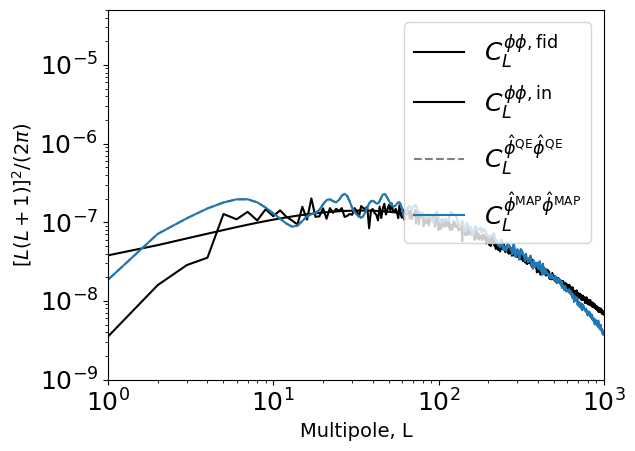

In [5]:
from delensalot.utils_hp import alm_copy
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, np.arange(ana_mwe.itmax))
plm_in = alm_copy(ana_mwe._sims.get_sim_plm(0), ana_mwe._sims.lmax+ana_mwe._sims.dlmax, *ana_mwe.lm_max_qlm)

print('Loaded {} iterations'.format(len(plm_MAP)))

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$', color='black')
plt.plot(scale_factor*hp.alm2cl(plm_in), label=r'$C_L^{\phi\phi,{\rm in}}$', color='black')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/fsky, label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$', color='grey', ls='--')
for n in range(0, len(plm_MAP)):
    label = r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$' if n == 0 else None
    plt.plot(scale_factor*hp.alm2cl(plm_MAP[n])/fsky, label=label)
    # plt.plot(scale_factor*hp.alm2cl(plm_mf)/fsky, label=label, color='black')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-5)
plt.yscale('log')

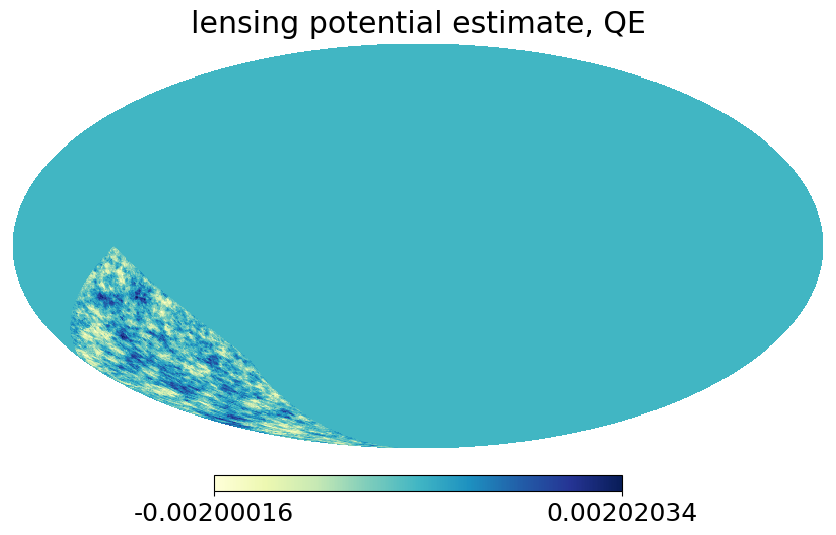

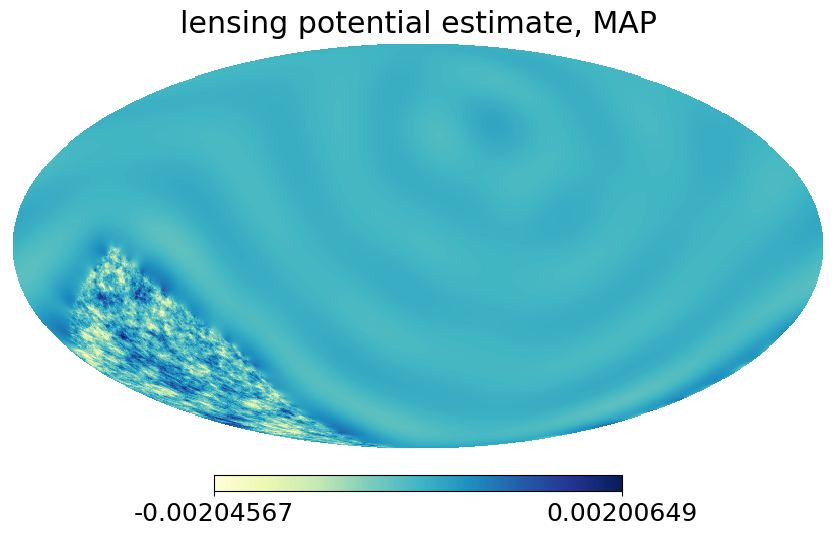

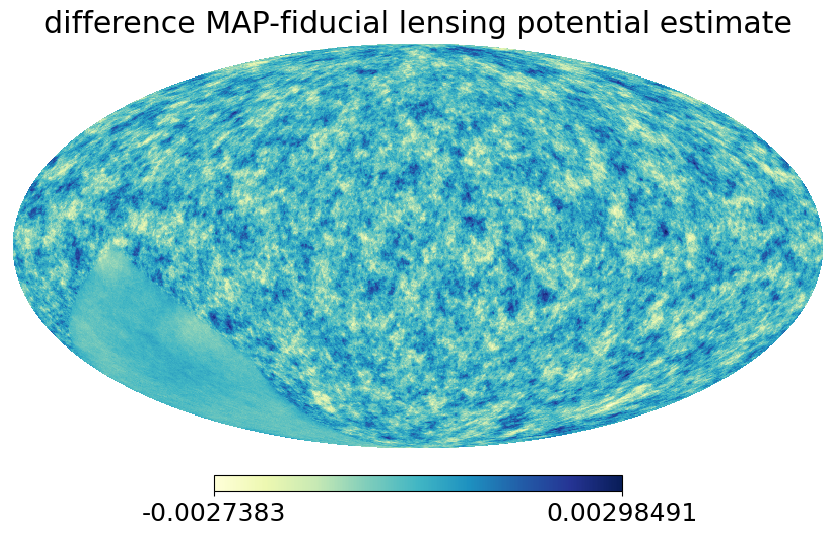

In [26]:
# mask_degrade = hp.ud_grade(mask, nside_out=512)
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=512)*mask_degrade, cmap='YlGnBu', title='lensing potential estimate, QE')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP[-1]), nside=512), cmap='YlGnBu', title='lensing potential estimate, MAP')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP[-1]-plm_in), nside=512), cmap='YlGnBu', title='difference MAP-fiducial lensing potential estimate')

# Delensed spectrum
For both QE and iterative lensing reconstruction, delensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps

In [ ]:
ana_mwe = run(config=fn, job_id='delens', verbose=True)
ana_mwe.run()
ana_mwe = ana_mwe.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

In [ ]:
input_blensing = hp.map2alm(hp.alm2map(ana_mwe._sims.get_sim_blm(0), nside=2048), lmax=1024)
blt_MAP = ana_mwe.get_blt_it(0, 12)

In [8]:
ana_mwe_QE = run(config=fn, job_id='QE_lensrec', verbose=False).job
blt_QE = ana_mwe_QE.get_blt(0)

In [10]:
blens_residual_QE = input_blensing - blt_QE
blens_residual_MAP = input_blensing - blt_MAP

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

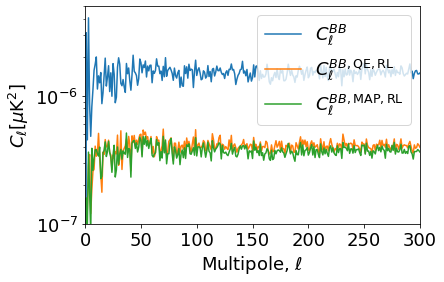

In [17]:
plt.plot(hp.alm2cl(input_blensing, lmax=300), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax=300)*np.mean(mask), label=r'$C_\ell^{BB,{\rm QE,RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax=300)*np.mean(mask), label=r'$C_\ell^{BB,{\rm MAP,RL}}$')

plt.legend()
plt.yscale('log')
plt.xlim(0,300)
plt.ylim(1e-7,5e-6)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

In [ ]:
print(20*'~.')
print('A_{lens}^{QE}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_QE, lmax=200)/hp.alm2cl(input_blensing, lmax=200))[30:200])))
print('A_{lens}^{MAP}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_MAP, lmax=200)/hp.alm2cl(input_blensing, lmax=200))[30:200])))
print(20*'~.')

# Summary and next steps
This tutorial demonstrated the usage of delensalot on a masked sky, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

delensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 
Further, it can calculate reconstruction noise `N0`, and `N1`, and make analytical predictions for the delensed power spectra.
It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot) for more.